<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/Delta_Climate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Delta Climate: Project Introduction**

Hi there! Welcome to Gail, Rekha, and Marina’s CIS-5450 Final Project.

Throughout this project we study the trend in surface temperature of land and ocean in the world. We will look into temperature trends in cities and countries. 

We start our analysis from Earth Surface Temperature, a publicly available dataset that was released by Berkeley. We will walk through the entire process by downloading and acquiring preliminary datasets, extracting features, conducting EDA, and data modeling.**bold text**

#**Step 1: Get the Data**

To get the data:

1. Go to this Kaggle link and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file kaggle.json
3. Upload the kaggle.json file to the default location in your Google Drive



In [1]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

In [4]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/kaggle.json ~/.kaggle/

In [5]:
# Download dataset
!!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

['Downloading climate-change-earth-surface-temperature-data.zip to /content',
 '',
 '  0% 0.00/84.7M [00:00<?, ?B/s]',
 '  6% 5.00M/84.7M [00:00<00:01, 48.0MB/s]',
 ' 12% 10.0M/84.7M [00:00<00:01, 42.9MB/s]',
 ' 21% 18.0M/84.7M [00:00<00:01, 56.1MB/s]',
 ' 30% 25.0M/84.7M [00:00<00:01, 52.9MB/s]',
 ' 39% 33.0M/84.7M [00:00<00:01, 53.6MB/s]',
 ' 48% 41.0M/84.7M [00:00<00:00, 49.9MB/s]',
 ' 58% 49.0M/84.7M [00:00<00:00, 56.3MB/s]',
 ' 67% 57.0M/84.7M [00:01<00:00, 62.6MB/s]',
 ' 77% 65.0M/84.7M [00:01<00:00, 66.8MB/s]',
 ' 93% 79.0M/84.7M [00:01<00:00, 87.6MB/s]',
 '',
 '100% 84.7M/84.7M [00:01<00:00, 65.5MB/s]']

In [6]:
# Unzip folder in Colab content folder
!unzip /content/climate-change-earth-surface-temperature-data.zip

Archive:  /content/climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [44]:
# Import necessary libraries
# import json
# import glob
import pandas as pd
# import numpy as np
# import datetime as dt
# import re
# import os
# import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib import cm
# from sklearn.model_selection import train_test_split

In [8]:
# Read csv file and save it to a dataframe
df_temp_by_city = pd.read_csv("GlobalLandTemperaturesByCity.csv")
df_temp_by_country = pd.read_csv("GlobalLandTemperaturesByCountry.csv")
df_temp_by_major_city = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
df_temp_by_state = pd.read_csv("GlobalLandTemperaturesByState.csv")
df_temp = pd.read_csv("GlobalTemperatures.csv")

#**Step 2: Data Exploration**

We are going to explore `df_temp_by_city` DF and look at the data types, number of cities, number of missing values, and number of countries.

In [9]:
df_temp_by_city.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [12]:
df_temp_by_city.dtypes
print("Total rows in temp_by_city df: ", len(df_temp_by_city))

Total rows in temp_by_city df:  8599212


In [14]:
cities = df_temp_by_city.City.unique()
print("Cities in the dataframe: ", len(cities))
print("Note, city count could be slightly off due to duplicates across countries")
cities_from_temp_list = cities.tolist()

Cities in the dataframe:  3448
Note, city count could be slightly off due to duplicates across countries


In [15]:
countries = df_temp_by_city.Country.unique()
print("Countries in the df: ",len(countries))

Countries in the df:  159


The number of row that miss temperature data is less than 5% of total number of rows 


In [22]:
missing_temp_df = df_temp_by_city.loc[df_temp_by_city['AverageTemperature'].isna()]
missing_temp_df.head()
print("Total number of rows with temp data missing: ",len(missing_temp_df))
print("Percentage of rows with missing temp data: {:.2f}%".format(len(missing_temp_df) / len(df_temp_by_city) * 100))

Total number of rows with temp data missing:  364130
Percentage of rows with missing temp data: 4.23%


Next, we find all the cities with missing values and create a series to find the number of such cities. We conclude that almost every city has a few missing values.

Following that, we find the number of missing values per city, using groupby and storing the result in `cities_mv_summary`. Then, we calculate the percentage of missing values per city.

Finally, we print the report on cities with missing values at 8, 10, 12, 15, 18, and 20 percent to help us make the decision for the acceptable level missing values.

In [26]:
#from numpy.core.multiarray import inner
cities_missing_values = missing_temp_df.City.unique()
print("Cities with missing values:", len(cities_missing_values))

# new DF with the number missing values by City (dropped unnecessary columns)
cities_mv_summary = missing_temp_df.groupby(['City']).count().drop(columns=['Country','Latitude','Longitude']).reset_index()
cities_mv_summary = cities_mv_summary.sort_values(by = 'City',ascending=False) 
#cities_mv_summary.head()

# Create a new DF with count of total values per City from original DF 
cities_total_values = df_temp_by_city.groupby(['City']).count().drop(columns=['Country','Latitude','Longitude']).reset_index()
# Merge two DFs and add a column missing_Temp_percent to calculate percentage of missing values by City
cities_mv_total = cities_mv_summary.merge(cities_total_values,left_on= 'City',right_on= 'City', how ='inner')
#cities_mv_total.head()
cities_mv_total = cities_mv_total.assign(missing_temp_percent=lambda x: (x.dt_x/x.dt_y)*100)
cities_mv_total = cities_mv_total.sort_values(by = 'missing_temp_percent',ascending= False)
#cities_mv_total.head()

# Print a report on number of cities with missing Temperature Values > 8,10,12,15,17,20 percent
percent_list = [8,10,12,15,17,20]
for x in percent_list:
  cities_to_drop = cities_mv_total.loc[cities_mv_total['missing_temp_percent']> x] 
  print("percent of Nan", x,":-number of cities to drop:",len(cities_to_drop))

# Making the decision to drop missing value > 12 percent
cities_to_drop = cities_mv_total.loc[cities_mv_total['missing_temp_percent']> 12] 
cities_to_drop.head()

Cities with missing values: 3323
percent of Nan 8 :-number of cities to drop: 746
percent of Nan 10 :-number of cities to drop: 391
percent of Nan 12 :-number of cities to drop: 314
percent of Nan 15 :-number of cities to drop: 184
percent of Nan 17 :-number of cities to drop: 170
percent of Nan 20 :-number of cities to drop: 18


,City,dt_x,AverageTemperature_x,AverageTemperatureUncertainty_x,dt_y,AverageTemperature_y,AverageTemperatureUncertainty_y,missing_temp_percent
1013,Port Louis,1039,0,0,2721,1682,1682,38.184491
807,Saint Denis,1039,0,0,2721,1682,1682,38.184491
2438,Fianarantsoa,1036,0,0,2721,1685,1685,38.074237
1369,Nacala,958,0,0,2721,1763,1763,35.207644
3197,Antananarivo,958,0,0,2721,1763,1763,35.207644


[Text(0.5, 1.0, 'Total Number of Cities vs Cities with missing values vs Cities we dropped')]

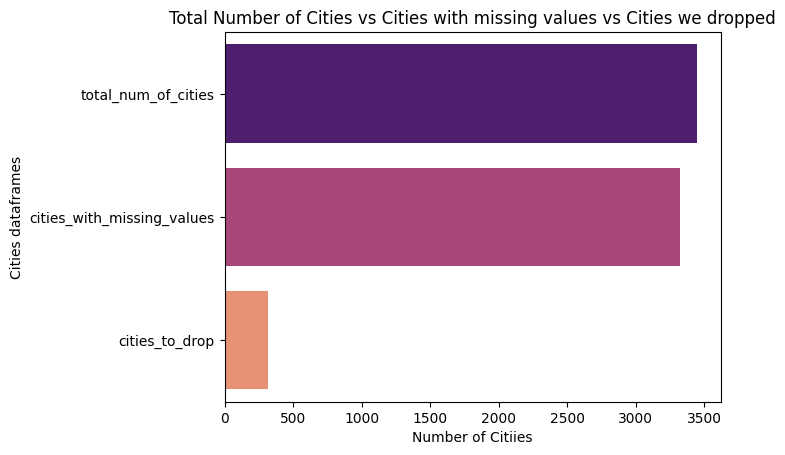

In [70]:
# Visualising out findings from analysis of missing values
d = {'total_num_of_cities': len(cities), 
     'cities_with_missing_values': len(cities_missing_values), 
     'cities_to_drop': len(cities_to_drop)}
vis_df = pd.DataFrame(d, index=list(range(0, 1)))

g = sns.barplot(data=vis_df, palette='magma', orient='h')
g.set(xlabel='Number of Citiies', ylabel='Cities dataframes')
g.set(title="Total Number of Cities vs Cities with missing values vs Cities we dropped")

As we can see, we can drop cities with >12% missing values and lose less than 10% of the cities. 

The guidelines for missing values in Metereology also recommend not using months with greater than 3 consecutive days or 5 days in total in computing monthly averages.
https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.5801

As an approximation to this rule, we drop cities with more than 12% of missing data. These rows have been flagged below.


In [69]:
cities_to_drop_list = cities_to_drop['City'].tolist()

df_temp_by_city['drop_city'] = df_temp_by_city['City'].apply(lambda x: 1 if x in cities_to_drop_list else 0)
df_temp_by_city.head()
df_temp_by_city.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E,0
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E,0
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E,0
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E,0
8599211,2013-09-01,NaN,NaN,Zwolle,Netherlands,52.24N,5.26E,0


We again look at the dataset.

In [ ]:
# Data types
df_temp_by_city.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
drop_city                          int64
dtype: object

In [ ]:
# Number of missing values is still 364140
df_temp_by_city.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
drop_city                             0
dtype: int64

In [ ]:
# There is no change in the number of rows after calling drop_duplicates(). Therefore, there is no need to drop duplicates.
len(df_temp_by_city) - len(df_temp_by_city.drop_duplicates())

0

Next, we do the following:
1. Remove the nulls in AverageTemperature
2. To simplify analysis, drop unnecessary columns
3. To allow timeseries, convert dt type from object to datetime


In [ ]:
# Drop null values
df_temp_by_city_clean = df_temp_by_city.dropna()

In [ ]:
# Number of missing values is now zero
df_temp_by_city_clean.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
drop_city                        0
dtype: int64

In [ ]:
# cast dt as datetime
df_temp_by_city_clean['date'] =  pd.to_datetime(df_temp_by_city_clean['dt'], format='%Y-%m-%d')

<ipython-input-56-711b2c5cb02a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_by_city_clean['date'] =  pd.to_datetime(df_temp_by_city_clean['dt'], format='%Y-%m-%d')


In [ ]:
# check type of datetime column
df_temp_by_city_clean.dtypes

dt                                       object
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
drop_city                                 int64
date                             datetime64[ns]
dtype: object

In [ ]:
# drop columns
df_temp_by_city_clean = df_temp_by_city_clean.drop(columns=['drop_city', 'dt'])

In [ ]:
df_temp_by_city_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8235082 entries, 0 to 8599210
Data columns (total 7 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   AverageTemperature             float64       
 1   AverageTemperatureUncertainty  float64       
 2   City                           object        
 3   Country                        object        
 4   Latitude                       object        
 5   Longitude                      object        
 6   date                           datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 502.6+ MB


Repeat the cleaning process on the other datasets.

In [ ]:
df_temp_by_country.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [ ]:
# no duplicates
len(df_temp_by_country)-len(df_temp_by_country.drop_duplicates())

0

In [ ]:
# drop nulls
# df_temp_by_country.isna().sum()
df_temp_by_country_clean = df_temp_by_country.dropna()
df_temp_by_country_clean.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

In [ ]:
# convert dt to datetime and drop
df_temp_by_country_clean["date"] = pd.to_datetime(df_temp_by_country_clean['dt'], format='%Y-%m-%d')
df_temp_by_country_clean = df_temp_by_country_clean.drop(columns=['dt'])

<ipython-input-72-b1d5ef5e82fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_by_country_clean["date"] = pd.to_datetime(df_temp_by_country_clean['dt'], format='%Y-%m-%d')


In [ ]:
df_temp_by_country_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544811 entries, 0 to 577460
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   AverageTemperature             544811 non-null  float64       
 1   AverageTemperatureUncertainty  544811 non-null  float64       
 2   Country                        544811 non-null  object        
 3   date                           544811 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 20.8+ MB


In [ ]:
df_temp_by_major_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [ ]:
# no duplicates
len(df_temp_by_major_city)-len(df_temp_by_major_city.drop_duplicates())

0

In [ ]:
# drop nulls
# df_temp_by_major_city.isna().sum()
df_temp_by_major_city_clean = df_temp_by_major_city.dropna()
df_temp_by_major_city_clean.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [ ]:
# convert dt to datetime and drop
df_temp_by_major_city_clean["date"] = pd.to_datetime(df_temp_by_major_city_clean['dt'], format='%Y-%m-%d')
df_temp_by_major_city_clean = df_temp_by_major_city_clean.drop(columns=['dt'])

<ipython-input-80-90ca39b26641>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_by_major_city_clean["date"] = pd.to_datetime(df_temp_by_major_city_clean['dt'], format='%Y-%m-%d')


In [ ]:
df_temp_by_major_city_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228175 entries, 0 to 239175
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   AverageTemperature             228175 non-null  float64       
 1   AverageTemperatureUncertainty  228175 non-null  float64       
 2   City                           228175 non-null  object        
 3   Country                        228175 non-null  object        
 4   Latitude                       228175 non-null  object        
 5   Longitude                      228175 non-null  object        
 6   date                           228175 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 13.9+ MB


In [ ]:
df_temp_by_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [ ]:
# no duplicates
len(df_temp_by_state)-len(df_temp_by_state.drop_duplicates())

0

In [ ]:
# drop nulls
# df_temp_by_state.isna().sum()
df_temp_by_state_clean = df_temp_by_state.dropna()
df_temp_by_state_clean.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

In [ ]:
# convert dt to datetime and drop
df_temp_by_state_clean["date"] = pd.to_datetime(df_temp_by_state_clean['dt'], format='%Y-%m-%d')
df_temp_by_state_clean = df_temp_by_state_clean.drop(columns=['dt'])

<ipython-input-91-e29e0a4b8b00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_by_state_clean["date"] = pd.to_datetime(df_temp_by_state_clean['dt'], format='%Y-%m-%d')


In [ ]:
df_temp_by_state_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620027 entries, 0 to 645673
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   AverageTemperature             620027 non-null  float64       
 1   AverageTemperatureUncertainty  620027 non-null  float64       
 2   State                          620027 non-null  object        
 3   Country                        620027 non-null  object        
 4   date                           620027 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 28.4+ MB


In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [ ]:
# no duplicates
len(df_temp)-len(df_temp.drop_duplicates())

0

In [ ]:
# drop nulls
# df_temp.isna().sum()
df_temp_clean = df_temp.dropna()
df_temp_clean.isna().sum()

dt                                           0
LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64

In [ ]:
# convert dt to datetime and drop
df_temp_clean["date"] = pd.to_datetime(df_temp_clean['dt'], format='%Y-%m-%d')
df_temp_clean = df_temp_clean.drop(columns=['dt'])

<ipython-input-93-2804d0cb3a58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_clean["date"] = pd.to_datetime(df_temp_clean['dt'], format='%Y-%m-%d')


In [ ]:
df_temp_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 1200 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   LandAverageTemperature                     1992 non-null   float64       
 1   LandAverageTemperatureUncertainty          1992 non-null   float64       
 2   LandMaxTemperature                         1992 non-null   float64       
 3   LandMaxTemperatureUncertainty              1992 non-null   float64       
 4   LandMinTemperature                         1992 non-null   float64       
 5   LandMinTemperatureUncertainty              1992 non-null   float64       
 6   LandAndOceanAverageTemperature             1992 non-null   float64       
 7   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
 8   date                                       1992 non-null   datetime64[ns]
dtypes: datetime64[ns]

# Tweets dataset
Disaster Tweets dataset:
Look for climate related tweets.
OECD Dataset on climate and Economic data . There are multiple aspects of cities and 2 datasets were chosen. One has climate data like heat stress days from 2001 to 2020. The other has GDP per capita data. This enables us to see the income level of the cities which are most impacted by climate change.

Mount the next dataset Tweets.csv

In [ ]:
!! kaggle datasets download -d vstepanenko/disaster-tweets

['Downloading disaster-tweets.zip to /content',
 '',
 '  0% 0.00/656k [00:00<?, ?B/s]',
 '',
 '100% 656k/656k [00:00<00:00, 75.7MB/s]']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/CIS-545_Earth_Temperatures_Project")

Mounted at /content/drive


In [ ]:
tweets_df = pd.read_csv('tweets.csv')
tweets_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Find all the unique keywords in the Tweets .csv file . Convert it to alist . Convert the Unique cities to alist. Export the Unique cities and Unique keywords to two different Csv  files through a DF step.  Open and read them manually. Select the keywords relevant to weather or Climate Change in the Excel . Continue Processing. 


In [ ]:
tweets_df.head()
keywords_list = tweets_df.keyword.unique().tolist()
print("unique key words count",len(keywords_list))
tweet_cities = tweets_df.location.unique().tolist()
print("unique cities in tweets",len(tweet_cities))
# Keyword List to Df 
keywords_df = pd.DataFrame(keywords_list,columns = ['Tweet keywords'])
# First Tweet keywords File below 
keywords_df.to_csv("tweet_keywords.csv")
# The Tweets Cities Df Below , City names are Dirty 
tweet_cities_df = pd.DataFrame(tweet_cities,columns = ['Tweet cities'])
# TweetCities File to see the cities and assess cleanliness 
tweet_cities_df.to_csv("tweet_cities")

unique key words count 219
unique cities in tweets 4505


The tweet keywords relevant to weather were selected manually from the downloaded tweet_keywords.csv and will now be used in the next cell to downselect the tweets to relevant tweets.

In [ ]:
tw_keywords_sel_df = pd.read_csv("tweet_keywords_select.csv")
tw_keywords_sel_df = tw_keywords_sel_df.loc[tw_keywords_sel_df['Selected'] == 'Y']
#tw_keywords_sel_df.head()
climate_tweets_df = tw_keywords_sel_df.merge(tweets_df,left_on= 'Tweet keywords',right_on = 'keyword',how = 'inner')
climate_tweets_df = climate_tweets_df[climate_tweets_df['location'].notna()]
print("tweets relevant to climate based disaster",len(climate_tweets_df))


tweets relevant to climate based disaster 1340


# OECD dataset

OECD FUA city dataset link
https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY
https://stats.oecd.org/Index.aspx?DataSetCode=CITIES#

In [ ]:
oecd_cities_climate = pd.read_csv("FUA_CITY_OECD_DATA.csv")
oecd_cities_climate.dtypes

FileNotFoundError: ignored

In [ ]:
oecd_cities_climate.head()
variables_tracked = oecd_cities_climate.Variable.unique()
print("variables tracked:",len(variables_tracked))
print(variables_tracked)

variables tracked: 25
['Heating degree days (Sum over a year of the differences between the threshold temperature (15.5°C) and the daily mean outdoor temperature when the daily mean outdoor temperature is below 15.5°C)'
 'Days of very strong heat stress (UTCI > 38°C)'
 'Cooling degree days (Sum over a year of the differences between the daily mean outdoor air temperature and the threshold temperature (22°C) when the daily mean outdoor temperature is above 22°C)'
 'Days of extreme heat stress (UTCI > 46°C)'
 'Days of strong heat stress (UTCI > 32°C)'
 'Additional days of very strong heat stress (UTCI > 38°C) compared to the 1981-2010 average'
 'Nightime urban heat island: difference in land surface temperature (in °C) between the built-up area and its surroundings'
 'Share of population esposed to river flooding, 50-year return period'
 'Share of population exposed to river flooding, 10-year return period'
 'Area burned as a share of total area'
 'Share of population exposed to coastal 

There are 25 climate variables tracked by city. We can flatten the data set and make the variables columns and put the dats in the row form for ease of use if we wish to look at all 25. Need to decide how to analyze. Below we check the number of cities and compare to the temperature dataset

In [ ]:
oecd_cities = oecd_cities_climate.loc[oecd_cities_climate['TL']=='CITY']
oecd_cities_list = oecd_cities.Geography.unique().tolist()
print("oecd cities count",len(oecd_cities_list))

oecd cities count 1385


OECD city gdp data is from link below https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY

GDP data exists here at country level but the city is called "Functional Urban Area"(FUA), The field VAR = GDP_REAL_PPP indicates per capita GDP in the city by year from 2001 and we can use this to rate the city amongst the cities. We can keep the data only for the year 2015 as GDP is normalized to prices in the year 2015. To be decided by the group

In [ ]:
oecd_cities_gdp = pd.read_csv("FUA_CITY_GDP.csv")
oecd_cities_gdp.head()
oecd_gdp_cities_list = oecd_cities_gdp.Geography.unique()
print("count of cities for gdp",len(oecd_gdp_cities_list))

count of cities for gdp 699


Keep only per capita GDP rows for the year 2015 . Put the cities into 4 quartiles where 1 is high gdp and 4 is lowest gdp

In [ ]:
oecd_quartile_list = oecd_cities_gdp.Value.quantile([0.25,0.50,0.75]).tolist()
print(oecd_quartile_list)

[8722.75, 39698.5, 100516.5]


In [ ]:
# hard coded values from above cell
def quartile_calc(x):

  if x < 11519.0:
    return 4
  else:
    if x < 19741.0:
      return 3
    else:
      if x< 38664.5:
        return 2
      else:
        return 1

oecd_cities_gdp = oecd_cities_gdp.loc[oecd_cities_gdp['VAR']== "GDP_REAL_PPP" ]
oecd_cities_gdp = oecd_cities_gdp.loc[oecd_cities_gdp['TIME'] == 2015]
#oecd_cities_gdp.head()


oecd_cities_gdp = oecd_cities_gdp.assign(Quartile = lambda x : x.Value.apply(quartile_calc) )
#oecd_cities_gdp.head()

The oecd cities all have a GEO field and we will use this to merge in gdp quartile data where applicable. The GDP is at the Functional Urban Area level whereas the climate data is both at the FUA level and the city level. For the purposes of impact of extreme weather on lower income neighborhoods, it is probably better to use the FUA level analysis. 


In [ ]:
oecd_cities_climate_gdp = oecd_cities_climate.merge(oecd_cities_gdp[['GEO','Quartile']],left_on = 'GEO', right_on ='GEO',how = 'left' )
oecd_full_cities_list = oecd_cities_climate_gdp.Geography.unique().tolist()
oecd_cities_climate_gdp.tail()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags,Quartile
650546,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2017,2017,0.0,NaN,NaN,NaN
650547,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2018,2018,0.0,NaN,NaN,NaN
650548,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2019,2019,0.0,NaN,NaN,NaN
650549,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2020,2020,0.0,NaN,NaN,NaN
650550,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2021,2021,0.0,NaN,NaN,NaN


Look for the matches in city names between the temperature data set and OECD data set. There appear to be 528 ( see code cell output below)
Conclusions:
 temperature dataset can drop cities with too much missing data. 
 temperature dataset can possibly interpolate values for missing data for cities that are retained.
 the temperature data set can be used to days of heat stress.
 We can match the cities in the 2 data sets for deeper analysis

In [ ]:

cities_temp_and_oecd = []
# cities_from_temp_list has the cities from df_city_temp, oecd_full_cities_list has cities from oecd datasets after merge
# code below finds the common cities
for x in cities_from_temp_list:
  if x in oecd_full_cities_list:
    cities_temp_and_oecd.append(x)
print(len(cities_temp_and_oecd))

528


The OECD dataset has used temperatures of 32C,38C  and 46C to count days of heat stress on various levels. This is based on max temperatures. Our dataset has average temperatures where night time temperatures beging down the value. We are using over 32 degrees average to flag heat stress at any level for this analysis. This average tempearature higher than 89.6F which would normally guarantee a daytime high of around 100F given reasonable variations of 20F from day to night max to min. Simple analysis of philadelphia is done as an exploratory exercise


In [ ]:
#extract the data for philadelphia 
df_temp_phily = df_temp_by_city.loc[df_temp_by_city['City']=="Philadelphia"]
df_temp_phily['date'] = pd.to_datetime(df_temp_phily['dt'],format ='%Y-%m-%d' )
df_temp_phily.head()

<ipython-input-19-a99f10c48c32>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_phily['date'] = pd.to_datetime(df_temp_phily['dt'],format ='%Y-%m-%d' )


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city,date
5846209,1743-11-01,6.072,1.74,Philadelphia,United States,39.38N,74.91W,0,1743-11-01
5846210,1743-12-01,NaN,NaN,Philadelphia,United States,39.38N,74.91W,0,1743-12-01
5846211,1744-01-01,NaN,NaN,Philadelphia,United States,39.38N,74.91W,0,1744-01-01
5846212,1744-02-01,NaN,NaN,Philadelphia,United States,39.38N,74.91W,0,1744-02-01
5846213,1744-03-01,NaN,NaN,Philadelphia,United States,39.38N,74.91W,0,1744-03-01


Test time series forecasting on Phily data

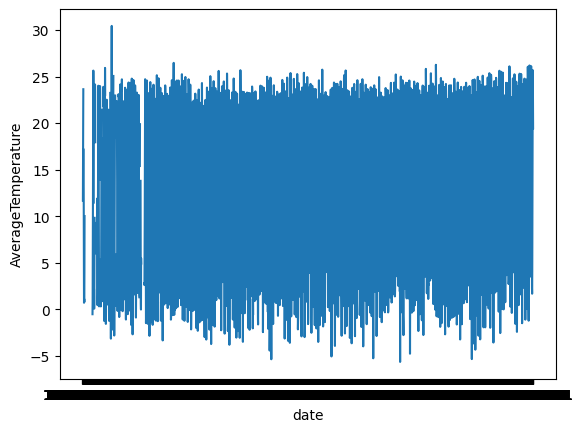

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.ylabel("AverageTemperature")
plt.xlabel("date")
plt.plot(df_temp_phily.dt,df_temp_phily.AverageTemperature)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

Text(0.5, 0, 'prediction for 5 years from 2009')

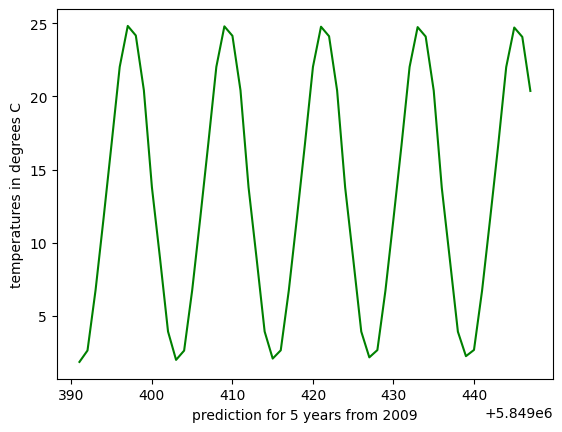

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train = df_temp_phily[df_temp_phily['date'] < pd.to_datetime("2008-12-31", format='%Y-%m-%d')]
test=   df_temp_phily[df_temp_phily['date'] > pd.to_datetime("2008-12-31",format = '%Y-%m-%d')]

y_temp = train['AverageTemperature']
smax_model = SARIMAX(y_temp,order=(2,2,2),seasonal_order = (2,2,2,12))
smax_model = smax_model.fit()
y_temp = smax_model.get_forecast(len(test.index))
y_temp_df = y_temp.conf_int(alpha = 0.05)
y_temp_df['Predicted_temp'] = smax_model.predict(start = y_temp_df.index[0],end = y_temp_df.index[-1])
y_temp_df.index = test.index
#y_temp_df.head()
#y_temp_df = y_temp_df.merge(test[['date']] ,left_on = 'index',right_on = 'index', how = 'inner')
y_temp_df.head(50)

plt.plot(y_temp_df['Predicted_temp'],color = 'green', label = 'Predicted temp')
plt.ylabel("temperatures in degrees C")
plt.xlabel("prediction for 5 years from 2009")

# OECD dataset

https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY

Create link to project folder in google drive
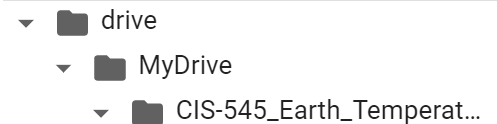

In [ ]:
# Download dataset
df_demography = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Demography.csv")
df_economy = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Economy.csv")
df_air_pollution = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Air_pollution.csv")
df_climate_hazards = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Climate_hazards.csv")
df_territorial_organization = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Territorial_Organization.csv")


In [ ]:
df_city_demography.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2001,2001,19272100.0,NaN,NaN
1,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2002,2002,19492800.0,NaN,NaN
2,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2003,2003,19718400.0,NaN,NaN
3,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2004,2004,19930400.0,NaN,NaN
4,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2005,2005,20174500.0,NaN,NaN


In [ ]:
df_city_demography.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243223 entries, 0 to 243222
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LOCATION         243223 non-null  object 
 1   Country          243223 non-null  object 
 2   TL               243223 non-null  object 
 3   Territory level  243223 non-null  object 
 4   GEO              243223 non-null  object 
 5   Geography        243223 non-null  object 
 6   VAR              243223 non-null  object 
 7   Variable         243223 non-null  object 
 8   TIME             243223 non-null  int64  
 9   Time             243223 non-null  int64  
 10  Value            243223 non-null  float64
 11  Flag Codes       0 non-null       float64
 12  Flags            0 non-null       float64
dtypes: float64(3), int64(2), object(8)
memory usage: 24.1+ MB


To clean this dataset,
1. Drop unnecessary and redundant columns
2. Check for duplicates and nullls

In [ ]:
# LOCATION is the three-letter code of country. We will be using the full name of countries, so we can remove this column.
df_city_demography["LOCATION"].unique()

array(['AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'HUN', 'IRL', 'ISL', 'ITA',
       'USA', 'CHE', 'CHL', 'COL', 'JPN', 'CZE', 'DEU', 'KOR', 'LTU',
       'LUX', 'LVA', 'MEX', 'DNK', 'ESP', 'MLT', 'NLD', 'NOR', 'NZL',
       'POL', 'EST', 'FIN', 'FRA', 'PRT', 'GBR', 'ROU', 'SVK', 'SVN',
       'SWE', 'TUR', 'GRC', 'HRV'], dtype=object)

In [ ]:
# df_city_demography["TL"].unique() # 'COUNTRY', 'FUA', 'CITY' # can be removed
df_city_demography["Territory level"].unique() # 'Country', 'Functional Urban Area', 'City'

array(['Country', 'Functional Urban Area', 'City'], dtype=object)

In [ ]:
# df_city_demography["GEO"].unique() # can be removed
# df_city_demography["Geography"].unique()

array(['AUS', 'AUS01F', 'AUS01C', ..., 'USA149F', 'USA149C', 'USA14F'],
      dtype=object)

In [ ]:
# df_city_demography["VAR"].unique() # can be removed
df_city_demography["Variable"].unique()

array(['Population, all ages, administrative data',
       'Youth population group (0-14)',
       'Working age population group (15-64)',
       'Elderly population group (65+)',
       'Youth dependency ratio (-15 over population 15-64)',
       'Elderly dependency ratio (65+ over population 15-64)',
       'Growth/shrinking index of the total population (2010=100)',
       'Population of the metropolitan area as a share of the national population'],
      dtype=object)

In [ ]:
# These two columns are the same so remove one
df_city_demography["TIME"].unique() # can be removed
df_city_demography["Time"].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
df_city_demography_clean = df_city_demography.drop(columns = ['LOCATION', 'TL', 'GEO', 'VAR', 'TIME', 'Flag Codes', 'Flags'])

In [ ]:
# no duplicates
len(df_city_demography_clean) - len(df_city_demography_clean.drop_duplicates())

0

In [ ]:
# no nulls
df_city_demography_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243223 entries, 0 to 243222
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Country          243223 non-null  object 
 1   Territory level  243223 non-null  object 
 2   Geography        243223 non-null  object 
 3   Variable         243223 non-null  object 
 4   Time             243223 non-null  int64  
 5   Value            243223 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 11.1+ MB


Repeat the cleaning process on the other datasets

In [ ]:
df_economy.head()

,Country,Geography,Variable,Time,Value
0,Spain,Barcelona,"Labour productivity (GDP per worker in USD, co...",2001,80384.0
1,Spain,Barcelona,"Labour productivity (GDP per worker in USD, co...",2002,82528.0
2,Spain,Barcelona,"Labour productivity (GDP per worker in USD, co...",2003,82882.0
3,Spain,Barcelona,"Labour productivity (GDP per worker in USD, co...",2004,82727.0
4,Spain,Barcelona,"Labour productivity (GDP per worker in USD, co...",2005,82931.0


In [ ]:
df_economy["Territory level"].unique() # 'Functional Urban Area' only. # can be removed

array(['Functional Urban Area'], dtype=object)

In [ ]:
df_economy_clean = df_economy.drop(columns = ['LOCATION', 'TL', 'Territory level', 'GEO', 'VAR', 'TIME', 'Flag Codes', 'Flags'])

In [ ]:
df_economy_clean["Variable"].unique() 

array(['Labour productivity (GDP per worker in USD, constant prices, constant PPP, base year 2015)',
       'GDP (Million USD, constant prices, constant PPP, base year 2015)',
       'GDP per capita (USD, constant prices, constant PPP, base year 2015)',
       'GDP of the metropolitan area as a share of the national GDP',
       'Employment at place of work'], dtype=object)

In [ ]:
# no duplicates
len(df_economy_clean) - len(df_economy_clean.drop_duplicates())

In [ ]:
# no nulls
df_economy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62688 entries, 0 to 62687
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    62688 non-null  object 
 1   Geography  62688 non-null  object 
 2   Variable   62688 non-null  object 
 3   Time       62688 non-null  int64  
 4   Value      62688 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.4+ MB


In [ ]:
df_air_pollution.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2000,2000,0.0,NaN,NaN
1,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2001,2001,0.0,NaN,NaN
2,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2002,2002,0.0,NaN,NaN
3,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2003,2003,0.0,NaN,NaN
4,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2004,2004,0.0,NaN,NaN


In [ ]:
df_air_pollution["Territory level"].unique() # has both FUA and City so keep

array(['Functional Urban Area', 'City'], dtype=object)

In [ ]:
df_air_pollution_clean = df_air_pollution.drop(columns = ['LOCATION', 'TL', 'GEO', 'VAR', 'TIME', 'Flag Codes', 'Flags'])

In [ ]:
df_air_pollution_clean["Variable"].unique() 

array(['Share of population exposed to a level of PM2.5 above 15 µg/m3',
       'Share of population exposed to a level of PM2.5 above 5 µg/m3',
       'Share of population exposed to a level of PM2.5 above 10 µg/m3',
       'Mean population exposure to PM2.5 air pollution',
       'Share of population exposed to a level of PM2.5 above 35 µg/m3',
       'Share of population exposed to a level of PM2.5 above 25 µg/m3'],
      dtype=object)

In [ ]:
# no duplicates
len(df_air_pollution_clean) - len(df_air_pollution_clean.drop_duplicates())

0

In [ ]:
# no nulls
df_air_pollution_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334530 entries, 0 to 334529
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Country          334530 non-null  object 
 1   Territory level  334530 non-null  object 
 2   Geography        334530 non-null  object 
 3   Variable         334530 non-null  object 
 4   Time             334530 non-null  int64  
 5   Value            334530 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 15.3+ MB


In [ ]:
df_climate_hazards.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,USA,United States,FUA,Functional Urban Area,USA117F,Scott,HDD,Heating degree days (Sum over a year of the di...,2001,2001,2838.0,NaN,NaN
1,USA,United States,FUA,Functional Urban Area,USA117F,Scott,HDD,Heating degree days (Sum over a year of the di...,2002,2002,2943.0,NaN,NaN
2,USA,United States,FUA,Functional Urban Area,USA117F,Scott,HDD,Heating degree days (Sum over a year of the di...,2003,2003,3084.0,NaN,NaN
3,USA,United States,FUA,Functional Urban Area,USA117F,Scott,HDD,Heating degree days (Sum over a year of the di...,2004,2004,2849.0,NaN,NaN
4,USA,United States,FUA,Functional Urban Area,USA117F,Scott,HDD,Heating degree days (Sum over a year of the di...,2005,2005,2858.0,NaN,NaN


In [ ]:
df_climate_hazards["Territory level"].unique() # has both FUA and City so keep

array(['Functional Urban Area', 'City'], dtype=object)

In [ ]:
df_climate_hazards_clean = df_climate_hazards.drop(columns = ['LOCATION', 'TL', 'GEO', 'VAR', 'TIME', 'Flag Codes', 'Flags'])

In [ ]:
df_climate_hazards_clean["Variable"].unique() 

array(['Heating degree days (Sum over a year of the differences between the threshold temperature (15.5°C) and the daily mean outdoor temperature when the daily mean outdoor temperature is below 15.5°C)',
       'Days of very strong heat stress (UTCI > 38°C)',
       'Cooling degree days (Sum over a year of the differences between the daily mean outdoor air temperature and the threshold temperature (22°C) when the daily mean outdoor temperature is above 22°C)',
       'Days of extreme heat stress (UTCI > 46°C)',
       'Days of strong heat stress (UTCI > 32°C)',
       'Area burned as a share of total area',
       'Share of population exposed to coastal flooding, 100-year return period',
       'Share of population exposed to at least one forest fire',
       'Summer daytime urban heat island: difference in land surface temperature (in °C) between the built-up area and its surroundings',
       'Share of population exposed to river flooding, 100-year return period'],
      dtype=objec

In [ ]:
# no duplicates
len(df_climate_hazards_clean) - len(df_climate_hazards_clean.drop_duplicates())

0

In [ ]:
# no nulls
df_climate_hazards_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393624 entries, 0 to 393623
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Country          393624 non-null  object 
 1   Territory level  393624 non-null  object 
 2   Geography        393624 non-null  object 
 3   Variable         393624 non-null  object 
 4   Time             393624 non-null  int64  
 5   Value            393624 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 18.0+ MB


In [ ]:
df_territorial_organization.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,DEU,Germany,CITY,City,DE034C,Mönchengladbach,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,53.0,NaN,NaN
1,GRC,Greece,FUA,Functional Urban Area,EL006F,Volos,URB_AREA_PC,Urbanised area per capita (m² per capita),2014,2014,257.0,NaN,NaN
2,USA,United States,FUA,Functional Urban Area,USA112F,Cameron,URB_AREA_PC,Urbanised area per capita (m² per capita),2014,2014,233.0,NaN,NaN
3,POL,Poland,CITY,City,PL056C,Zabrze,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,32.0,NaN,NaN
4,POL,Poland,FUA,Functional Urban Area,PL008F,Bydgoszcz,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,82.0,NaN,NaN


In [ ]:
df_territorial_organization["Territory level"].unique() # has both FUA and City so keep

array(['City', 'Functional Urban Area'], dtype=object)

In [ ]:
df_territorial_organization_clean = df_territorial_organization.drop(columns = ['LOCATION', 'TL', 'GEO', 'VAR', 'TIME', 'Flag Codes', 'Flags'])

In [ ]:
df_territorial_organization_clean["Variable"].unique() 

array(['Urbanised area (built-up area or land for urban use in km²)',
       'Urbanised area per capita (m² per capita)',
       'Total land area (in km²)',
       'Average population size of local governments',
       'Territorial fragmentation (local governments per 100 000 inhabitants)',
       'Population density (inhabitants per km²)',
       'Local governments (count)'], dtype=object)

In [ ]:
# no duplicates
len(df_territorial_organization_clean) - len(df_territorial_organization_clean.drop_duplicates())

0

In [ ]:
# no nulls
df_territorial_organization_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84436 entries, 0 to 84435
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          84436 non-null  object 
 1   Territory level  84436 non-null  object 
 2   Geography        84436 non-null  object 
 3   Variable         84436 non-null  object 
 4   Time             84436 non-null  int64  
 5   Value            84436 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.9+ MB


# Next steps
1. Determine which attributes are important and convert "Variable" column values into columns.
2. Merge OECD data with Temperature data.
3. Check for any correlation. Visualize data. If needed, reduce dimensions.
3. Create test, train, and, if possible, validation datasets.
4. Train model and predict temperature change.
5. Evaluate performance of model.


